In [1]:
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
import pickle 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import corner

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import sys, platform, os
from numpy import sqrt, sin, cos, pi
import scipy.constants as cst

camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
tf.__version__

'2.8.0'

In [2]:
import scipy.integrate as integrate
import scipy.special as special     
from scipy.interpolate import CubicSpline
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.integrate import quad, dblquad

In [3]:
train_params = np.load('LHS_params_3dim15000_NL.npz')                #LHS  

In [4]:
print(train_params.files)                                       # Each of the keys has an 'np.array' of values

['h', 'omega_b', 'omega_cdm']


In [5]:
#print(train_params['omega_b'])

n_samples = len(train_params['h'])
print('number of training samples:', len(train_params['omega_b'])) 
print(train_params['h'])

number of training samples: 15000
[0.67319688 0.64603774 0.64533369 ... 0.64410694 0.79922128 0.64088539]


In [6]:
cosmo_params = np.zeros((len(train_params['h']), 3))
print(cosmo_params[4])

cosmo_params[:, 0] = train_params['h']
cosmo_params[:, 1] = train_params['omega_b']
cosmo_params[:, 2] = train_params['omega_cdm']

## Training input params:
h = cosmo_params[:, 0]
omega_b = cosmo_params[:, 1]
omega_c = cosmo_params[:, 2]

[0. 0. 0.]


In [7]:
with open('pk_data_3dim15000_NL1.pkl', 'rb') as f, open('pk_data_3dim15000_NL2.pkl', 'rb') as g:
    pk_matrix = pickle.load(f)
    pk_nonlin_matrix = pickle.load(g)

pk_matrix = np.asarray(pk_matrix).astype('float32')
pk_matrix.dtype

In [8]:
h.dtype

dtype('float64')

In [9]:
# Training input params and output param:

train_H0 = 100*h
train_omega_b = omega_b                       
train_omega_c = omega_c

train_pk = pk_matrix                    
train_pk_nonlin = pk_nonlin_matrix 
print("train_pk shape:", np.shape(train_pk))
print("train_pk_nonlin shape:", np.shape(train_pk_nonlin))
print(len(train_pk[4]))

train_pk shape: (15000, 500)
train_pk_nonlin shape: (15000, 500)
500


In [10]:
input_params = np.vstack([train_H0, train_omega_b, train_omega_c])                                        # 1x5000

input_params_transpose = np.transpose(input_params)
print(np.shape(input_params_transpose))
print(np.shape(train_pk))

input_data = pd.DataFrame(input_params_transpose)
input_data.columns = ['H0', 'Omega_b', 'Omega_cdm']

output_data = pd.DataFrame(np.log(train_pk))
output_data_nonlin = pd.DataFrame(np.log(train_pk_nonlin))
print(input_data)                                                         #5000x1
print(output_data)

(15000, 3)
(15000, 500)
              H0   Omega_b  Omega_cdm
0      67.319688  0.022178   0.068561
1      64.603774  0.021184   0.190529
2      64.533369  0.022300   0.179542
3      78.302820  0.019112   0.087469
4      77.897460  0.020983   0.113391
...          ...       ...        ...
14995  78.884192  0.024052   0.228719
14996  65.020868  0.020454   0.173662
14997  64.410694  0.020318   0.165328
14998  79.922128  0.020476   0.084416
14999  64.088539  0.024937   0.186182

[15000 rows x 3 columns]
            0         1         2         3         4         5         6    \
0      7.495950  7.519010  7.542068  7.565125  7.588181  7.611235  7.634288   
1      4.774085  4.797164  4.820243  4.843322  4.866400  4.889478  4.912556   
2      4.919706  4.942785  4.965863  4.988941  5.012019  5.035097  5.058174   
3      7.246171  7.269230  7.292288  7.315345  7.338401  7.361455  7.384508   
4      6.550915  6.573983  6.597050  6.620116  6.643181  6.666246  6.689309   
...         ...     

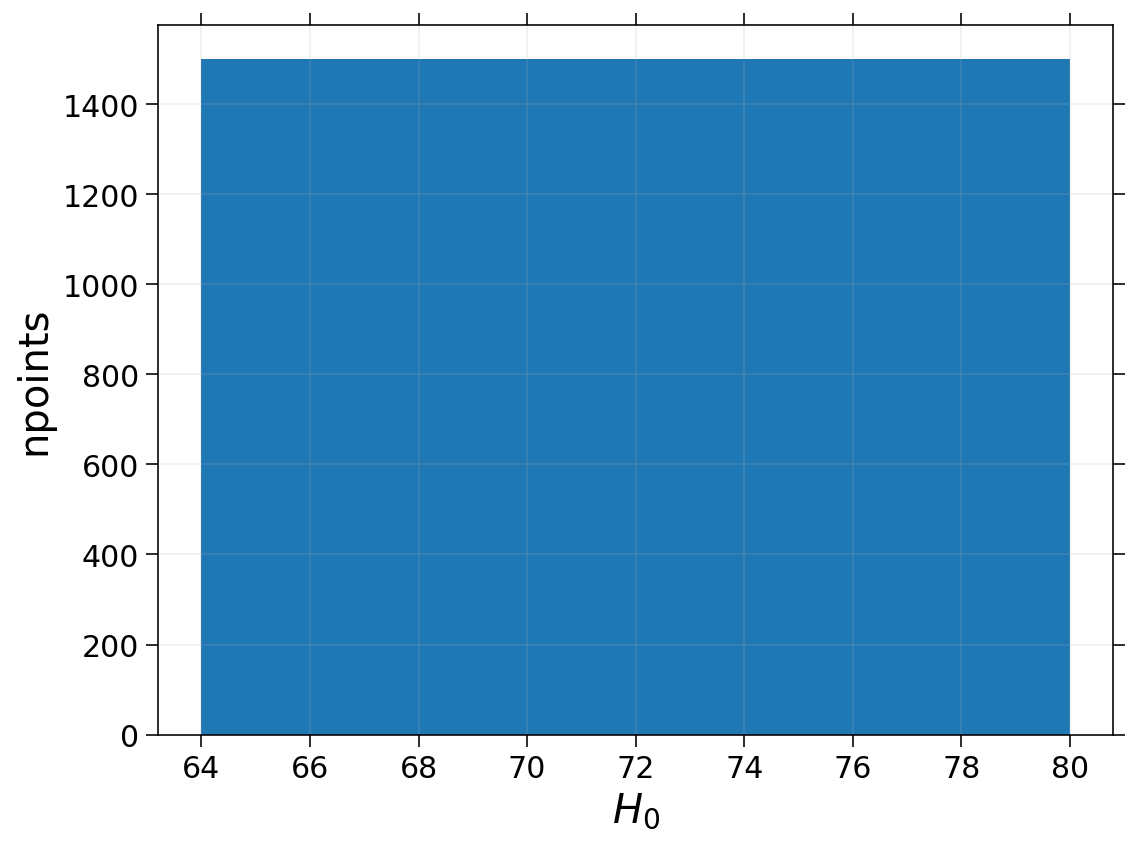

In [12]:
plt.figure(figsize = (8,6))
plt.hist(input_data['H0'])
#plt.hist(input_data['Omega_b'])
#plt.hist(input_data['Omega_cdm'])
plt.xlabel(r'$H_{0}$')
plt.ylabel('npoints')
plt.rc('axes', labelsize=16)
plt.rc('axes', labelsize=20, titlesize=20)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.grid(alpha=0.2)
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.tight_layout()

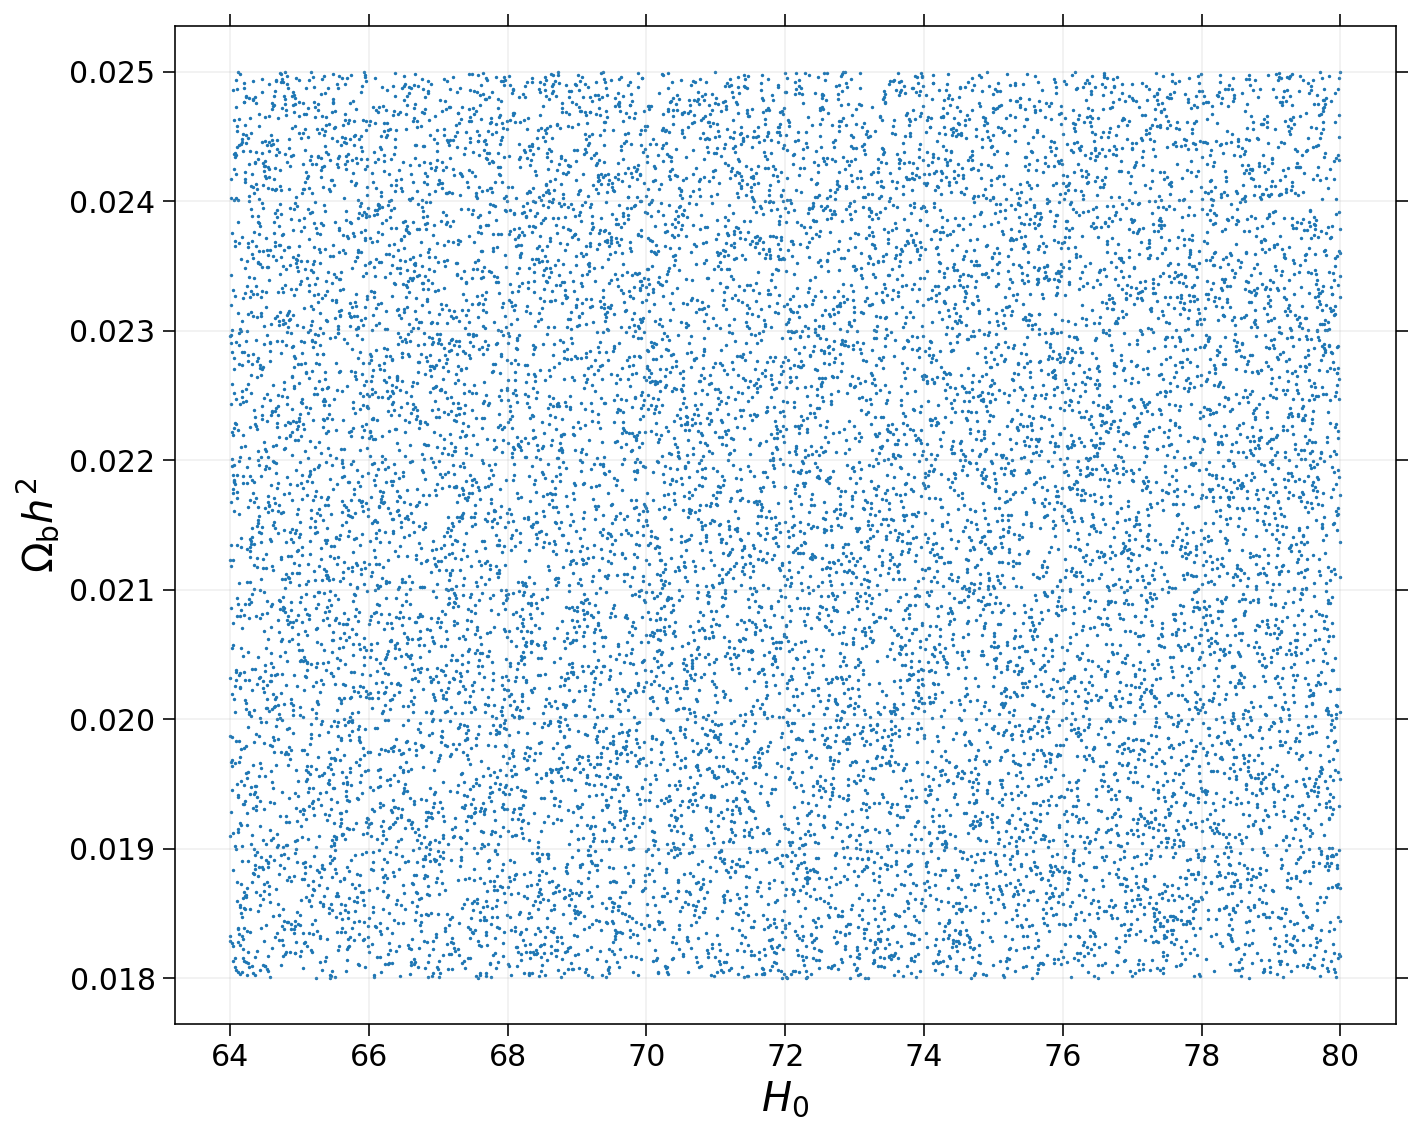

In [14]:
plt.figure(figsize = (10,8))
plt.scatter(input_data['H0'], input_data['Omega_b'], s=0.5)
plt.xlabel(r'$H_{0}$')
plt.ylabel(r'$\Omega_{\mathrm{b}}h^{2}$')
plt.rc('axes', labelsize=16)
plt.rc('axes', labelsize=20, titlesize=20)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.grid(alpha=0.2)
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.savefig('LHS_2dim.pdf')
plt.tight_layout()

In [15]:
# Standardising:

train_input_data = StandardScaler()
test_output_data = StandardScaler()

# Storing the fit object for later reference
scaled_input = train_input_data.fit(input_data.values)              # Compute the mean and std to be used for later scaling

scaled_output = test_output_data.fit(output_data.values)
scaled_output_nonlin = test_output_data.fit(output_data_nonlin.values)

# Generating the standardized values of input and output:
X = scaled_input.transform(input_data.values)                              # Perform standardisation by centring and scaling    
y = scaled_output.transform(output_data.values)     
y_nonlin = scaled_output_nonlin.transform(output_data_nonlin.values)
#print(X)

-1.7319353413637846 2.5870353073802956


(array([[1500., 1500., 1500., 1500., 1500., 1500., 1500., 1500., 1500.,
         1500.],
        [1500., 1500., 1500., 1500., 1500., 1500., 1500., 1500., 1500.,
         1500.],
        [1500., 1500., 1500., 1500., 1500., 1500., 1500., 1500., 1500.,
         1500.]]),
 array([-1.73193534e+00, -1.38554827e+00, -1.03916120e+00, -6.92774137e-01,
        -3.46387068e-01,  2.22044605e-16,  3.46387068e-01,  6.92774137e-01,
         1.03916120e+00,  1.38554827e+00,  1.73193534e+00]),
 <a list of 3 BarContainer objects>)

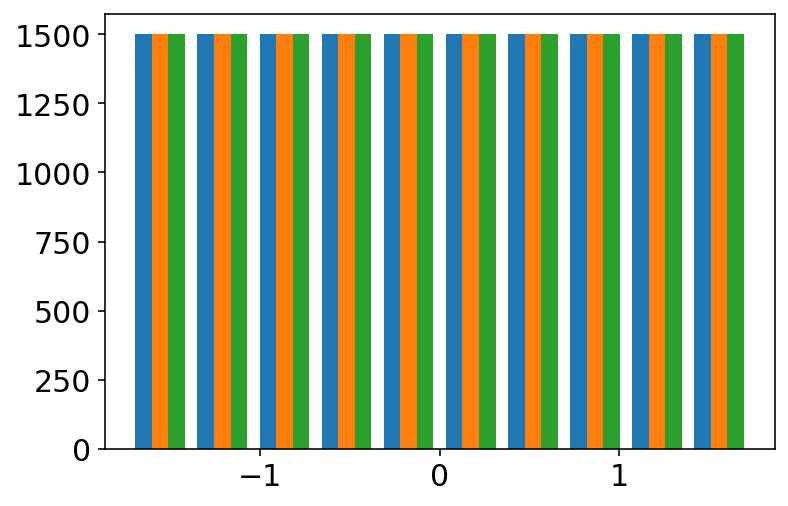

In [16]:
print(X.min(), y.max())
plt.hist(X)

In [17]:
# Split the data into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(np.shape(X_train))   
print(X_train.shape[1]) 


X_train_nonlin, X_test_nonlin, y_train_nonlin, y_test_nonlin = train_test_split(X, y_nonlin, test_size=0.2, random_state=42)
print(np.shape(X_train_nonlin))
print(X_train.shape[1])    

(12000, 3)
3
(12000, 3)
3


In [18]:
print("y_test samples, pts:", np.shape(y_test))
print("y_train samples, pts:", np.shape(y_train))
print("X_train samples, pts:", np.shape(X_train))
print("X_test samples, pts:",np.shape(X_test))

print("y_test_nonlin samples, pts:", np.shape(y_test_nonlin))
print("y_train_nonlin samples, pts:", np.shape(y_train_nonlin))
print("X_train_nonlin samples, pts:", np.shape(X_train_nonlin))
print("X_test_nonlin samples, pts:",np.shape(X_test_nonlin))
#print("X_train:", X_train)
#print("X_test:", X_test)

y_test samples, pts: (3000, 500)
y_train samples, pts: (12000, 500)
X_train samples, pts: (12000, 3)
X_test samples, pts: (3000, 3)
y_test_nonlin samples, pts: (3000, 500)
y_train_nonlin samples, pts: (12000, 500)
X_train_nonlin samples, pts: (12000, 3)
X_test_nonlin samples, pts: (3000, 3)


In [19]:
%%time
#Building the NN:

# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01,
#                                   patience=30, min_lr=0.000000001)
# e_s = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100)

tf_model = Sequential()
# Defining the input layer of the model
tf_model.add(Dense(units=500, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu')) # 
 
# Defining 1st Hidden layer of the model
tf_model.add(Dense(units=500, kernel_initializer='normal', activation='relu'))

tf_model.add(Dropout(0.1))

# Defining 2nd Hidden layer of the model
tf_model.add(Dense(units=500, kernel_initializer='normal', activation='relu'))

# Defining the 3rd hidden layer of the model
#tf_model.add(Dense(units=500, kernel_initializer='normal', activation='relu'))  

# Defining the 4th hidden layer of the model
#tf_model.add(Dense(units=500, kernel_initializer='normal', activation='relu')) 

#Defining the output layer of the model
tf_model.add(Dense(500, kernel_initializer='normal'))
 
# opt = keras.optimizers.Adam(learning_rate=1e-4)
opt = keras.optimizers.Adam(learning_rate=2e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)  
    
# Compiling the model
tf_model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
 
# Fitting the ANN to the Training set
hist_ = tf_model.fit(X_train, y_train, batch_size = 20, epochs = 500, validation_split=0.2, verbose=1) # callbacks=[reduce_lr, e_s],
            
# Mean absolute percentage error
MAPE = np.mean(np.abs((y_test - tf_model.predict(X_test))/y_test))*100
print(np.shape(100-MAPE))
print('Accuracy:', 100-MAPE)
#99.44523163935358, l_rate = 1e-4, 250 epochs, batch size = 50, 0.9837
#99.59918915882399, l_rate = 1e-4, 250 epochs, batch size = 20, 0.9934
tf_model.summary()

Epoch 1/500
480/480 [==============================] - 3s 6ms/step - loss: 48.8111 - accuracy: 0.0130 - val_loss: 9.1650 - val_accuracy: 0.0175
Epoch 2/500
480/480 [==============================] - 2s 5ms/step - loss: 4.0933 - accuracy: 0.0118 - val_loss: 2.9219 - val_accuracy: 0.0033
Epoch 3/500
480/480 [==============================] - 3s 5ms/step - loss: 2.7495 - accuracy: 0.0089 - val_loss: 2.2788 - val_accuracy: 0.0017
Epoch 4/500
480/480 [==============================] - 3s 5ms/step - loss: 2.1021 - accuracy: 0.0191 - val_loss: 1.7136 - val_accuracy: 0.0458
Epoch 5/500
480/480 [==============================] - 3s 5ms/step - loss: 1.6143 - accuracy: 0.0425 - val_loss: 1.2988 - val_accuracy: 0.0479
Epoch 6/500
480/480 [==============================] - 2s 5ms/step - loss: 1.2103 - accuracy: 0.0455 - val_loss: 0.9415 - val_accuracy: 0.0450
Epoch 7/500
480/480 [==============================] - 2s 5ms/step - loss: 0.8655 - accuracy: 0.0390 - val_loss: 0.6410 - val_accuracy: 0.036

Epoch 58/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0295 - accuracy: 0.1918 - val_loss: 0.0059 - val_accuracy: 0.3396
Epoch 59/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0299 - accuracy: 0.1964 - val_loss: 0.0057 - val_accuracy: 0.3696
Epoch 60/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0299 - accuracy: 0.2068 - val_loss: 0.0057 - val_accuracy: 0.3700
Epoch 61/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0298 - accuracy: 0.2010 - val_loss: 0.0051 - val_accuracy: 0.3721
Epoch 62/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0290 - accuracy: 0.2032 - val_loss: 0.0050 - val_accuracy: 0.3975
Epoch 63/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0290 - accuracy: 0.2099 - val_loss: 0.0061 - val_accuracy: 0.3638
Epoch 64/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0287 - accuracy: 0.2068 - val_loss: 0.0048 - val_accuracy:

Epoch 115/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0224 - accuracy: 0.2703 - val_loss: 0.0019 - val_accuracy: 0.4908
Epoch 116/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0229 - accuracy: 0.2533 - val_loss: 0.0030 - val_accuracy: 0.4996
Epoch 117/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0222 - accuracy: 0.2637 - val_loss: 0.0026 - val_accuracy: 0.5017
Epoch 118/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0226 - accuracy: 0.2640 - val_loss: 0.0026 - val_accuracy: 0.4842
Epoch 119/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0221 - accuracy: 0.2640 - val_loss: 0.0039 - val_accuracy: 0.4933
Epoch 120/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0218 - accuracy: 0.2708 - val_loss: 0.0052 - val_accuracy: 0.5075
Epoch 121/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0224 - accuracy: 0.2683 - val_loss: 0.0025 - val_ac

480/480 [==============================] - 2s 5ms/step - loss: 0.0195 - accuracy: 0.2826 - val_loss: 0.0013 - val_accuracy: 0.5121
Epoch 172/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0190 - accuracy: 0.2771 - val_loss: 0.0016 - val_accuracy: 0.5583
Epoch 173/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0189 - accuracy: 0.2930 - val_loss: 0.0031 - val_accuracy: 0.5146
Epoch 174/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0189 - accuracy: 0.2962 - val_loss: 0.0017 - val_accuracy: 0.5225
Epoch 175/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0195 - accuracy: 0.2945 - val_loss: 0.0040 - val_accuracy: 0.5354
Epoch 176/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0190 - accuracy: 0.2901 - val_loss: 0.0023 - val_accuracy: 0.5254
Epoch 177/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0187 - accuracy: 0.2796 - val_loss: 0.0045 - val_accuracy: 0.5317

480/480 [==============================] - 3s 6ms/step - loss: 0.0171 - accuracy: 0.3105 - val_loss: 0.0023 - val_accuracy: 0.5517
Epoch 228/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0169 - accuracy: 0.3217 - val_loss: 0.0011 - val_accuracy: 0.5033
Epoch 229/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0170 - accuracy: 0.3192 - val_loss: 0.0086 - val_accuracy: 0.5387
Epoch 230/500
480/480 [==============================] - 3s 5ms/step - loss: 0.0168 - accuracy: 0.3153 - val_loss: 0.0029 - val_accuracy: 0.5663
Epoch 231/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0170 - accuracy: 0.3123 - val_loss: 0.0047 - val_accuracy: 0.5342
Epoch 232/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0168 - accuracy: 0.3073 - val_loss: 0.0032 - val_accuracy: 0.5454
Epoch 233/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0169 - accuracy: 0.3151 - val_loss: 0.0064 - val_accuracy: 0.5325

480/480 [==============================] - 3s 6ms/step - loss: 0.0150 - accuracy: 0.3403 - val_loss: 0.0069 - val_accuracy: 0.6021
Epoch 284/500
480/480 [==============================] - 3s 6ms/step - loss: 0.0146 - accuracy: 0.3411 - val_loss: 0.0060 - val_accuracy: 0.5779
Epoch 285/500
480/480 [==============================] - 3s 6ms/step - loss: 0.0147 - accuracy: 0.3483 - val_loss: 0.0062 - val_accuracy: 0.6183
Epoch 286/500
480/480 [==============================] - 3s 6ms/step - loss: 0.0147 - accuracy: 0.3444 - val_loss: 0.0048 - val_accuracy: 0.5846
Epoch 287/500
480/480 [==============================] - 3s 6ms/step - loss: 0.0150 - accuracy: 0.3417 - val_loss: 0.0088 - val_accuracy: 0.5825
Epoch 288/500
480/480 [==============================] - 3s 6ms/step - loss: 0.0149 - accuracy: 0.3411 - val_loss: 0.0036 - val_accuracy: 0.5804
Epoch 289/500
480/480 [==============================] - 3s 5ms/step - loss: 0.0148 - accuracy: 0.3435 - val_loss: 0.0040 - val_accuracy: 0.5679

480/480 [==============================] - 2s 5ms/step - loss: 0.0129 - accuracy: 0.3572 - val_loss: 0.0065 - val_accuracy: 0.6062
Epoch 340/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0128 - accuracy: 0.3610 - val_loss: 0.0081 - val_accuracy: 0.6263
Epoch 341/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0131 - accuracy: 0.3689 - val_loss: 0.0088 - val_accuracy: 0.6121
Epoch 342/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0128 - accuracy: 0.3740 - val_loss: 0.0085 - val_accuracy: 0.5708
Epoch 343/500
480/480 [==============================] - 3s 5ms/step - loss: 0.0127 - accuracy: 0.3625 - val_loss: 0.0059 - val_accuracy: 0.6150
Epoch 344/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0129 - accuracy: 0.3606 - val_loss: 0.0018 - val_accuracy: 0.6104
Epoch 345/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0128 - accuracy: 0.3715 - val_loss: 0.0062 - val_accuracy: 0.6012

480/480 [==============================] - 2s 5ms/step - loss: 0.0113 - accuracy: 0.3861 - val_loss: 0.0092 - val_accuracy: 0.6408
Epoch 396/500
480/480 [==============================] - 3s 5ms/step - loss: 0.0112 - accuracy: 0.3885 - val_loss: 0.0105 - val_accuracy: 0.6196
Epoch 397/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0113 - accuracy: 0.3930 - val_loss: 0.0093 - val_accuracy: 0.6162
Epoch 398/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0110 - accuracy: 0.3870 - val_loss: 0.0053 - val_accuracy: 0.6617
Epoch 399/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0111 - accuracy: 0.3822 - val_loss: 0.0056 - val_accuracy: 0.6263
Epoch 400/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0107 - accuracy: 0.3880 - val_loss: 0.0041 - val_accuracy: 0.6229
Epoch 401/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0110 - accuracy: 0.3891 - val_loss: 0.0120 - val_accuracy: 0.6267

480/480 [==============================] - 2s 5ms/step - loss: 0.0092 - accuracy: 0.4210 - val_loss: 0.0096 - val_accuracy: 0.6496
Epoch 452/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0091 - accuracy: 0.4135 - val_loss: 0.0092 - val_accuracy: 0.6388
Epoch 453/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0088 - accuracy: 0.4167 - val_loss: 0.0079 - val_accuracy: 0.6488
Epoch 454/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0093 - accuracy: 0.4177 - val_loss: 0.0103 - val_accuracy: 0.6475
Epoch 455/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0092 - accuracy: 0.4103 - val_loss: 0.0022 - val_accuracy: 0.6496
Epoch 456/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0090 - accuracy: 0.4157 - val_loss: 0.0095 - val_accuracy: 0.6700
Epoch 457/500
480/480 [==============================] - 2s 5ms/step - loss: 0.0090 - accuracy: 0.4189 - val_loss: 0.0098 - val_accuracy: 0.6392

Total params: 753,500
Trainable params: 753,500
Non-trainable params: 0
_________________________________________________________________
Wall time: 20min 59s


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

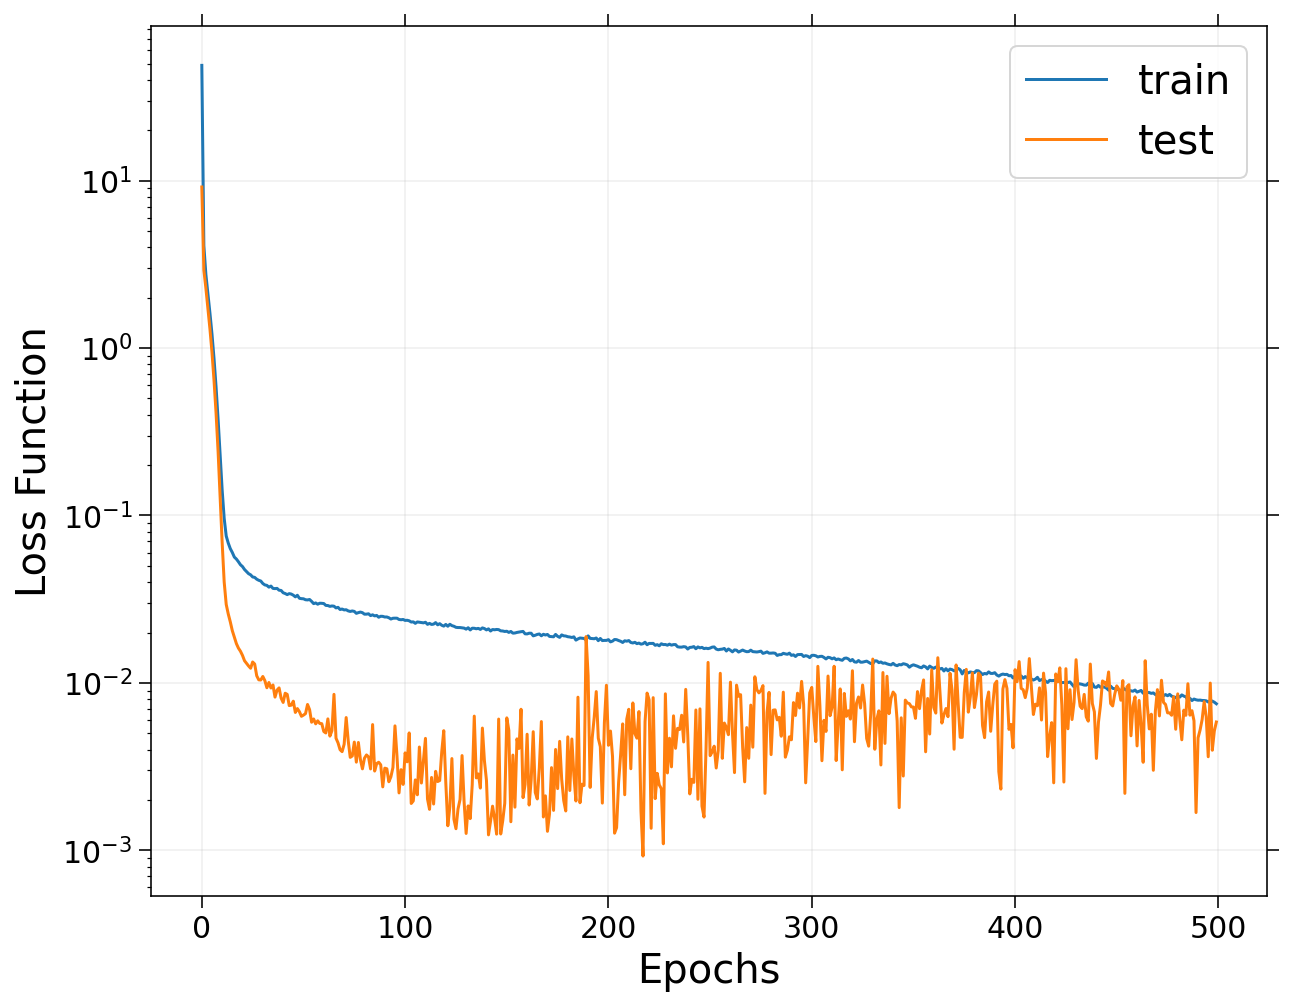

In [23]:
#Linear case:
plt.figure(figsize = (10,8))
plt.plot(hist_.history["loss"], label="train")
plt.plot(hist_.history["val_loss"], label="test")
plt.legend(fontsize=20)
plt.yscale("log")
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.rc('axes', labelsize=16)
plt.rc('axes', labelsize=20, titlesize=20)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.grid(alpha=0.2)
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.savefig('Loss_Func_3dim.pdf')
plt.tight_layout

In [21]:
%%time
#Building the NN for NONLINEAR:

# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01,
#                                   patience=30, min_lr=0.000000001)
# e_s = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100)

tf_model_nonlin = Sequential()
# Defining the input layer of the model
tf_model_nonlin.add(Dense(units=500, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu')) # 
 
# Defining 1st Hidden layer of the model
tf_model_nonlin.add(Dense(units=500, kernel_initializer='normal', activation='relu'))

tf_model_nonlin.add(Dropout(0.1))

# Defining 2nd Hidden layer of the model
tf_model_nonlin.add(Dense(units=500, kernel_initializer='normal', activation='relu'))

# Defining the 3rd hidden layer of the model
#tf_model_nonlin.add(Dense(units=500, kernel_initializer='normal', activation='relu'))  

# Defining the 4th hidden layer of the model
#tf_model_nonlin.add(Dense(units=500, kernel_initializer='normal', activation='relu')) 

#Defining the output layer of the model
tf_model_nonlin.add(Dense(500, kernel_initializer='normal'))
 
# opt = keras.optimizers.Adam(learning_rate=1e-4)
opt = keras.optimizers.Adam(learning_rate=2e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)  
    
# Compiling the model
tf_model_nonlin.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
 
# Fitting the ANN to the Training set
hist_nonlin = tf_model_nonlin.fit(X_train_nonlin, y_train_nonlin, batch_size = 20, epochs = 500, validation_split=0.2, verbose=1) # callbacks=[reduce_lr, e_s],
            
# Mean absolute percentage error
MAPE = np.mean(np.abs((y_test_nonlin - tf_model_nonlin.predict(X_test_nonlin))/y_test_nonlin))*100
print(np.shape(100-MAPE))
print('Accuracy:', 100-MAPE)
#99.44523163935358, l_rate = 1e-4, 250 epochs, batch size = 50, 0.9837
#99.59918915882399, l_rate = 1e-4, 250 epochs, batch size = 20, 0.9934
tf_model_nonlin.summary()

Epoch 1/500
480/480 [==============================] - 3s 7ms/step - loss: 0.5832 - accuracy: 0.0011 - val_loss: 0.1535 - val_accuracy: 0.0000e+00
Epoch 2/500
480/480 [==============================] - 3s 6ms/step - loss: 0.1113 - accuracy: 0.0061 - val_loss: 0.0845 - val_accuracy: 0.0137
Epoch 3/500
480/480 [==============================] - 3s 7ms/step - loss: 0.0652 - accuracy: 0.0288 - val_loss: 0.0530 - val_accuracy: 0.0433
Epoch 4/500
480/480 [==============================] - 3s 6ms/step - loss: 0.0448 - accuracy: 0.0441 - val_loss: 0.0380 - val_accuracy: 0.0592
Epoch 5/500
480/480 [==============================] - 3s 6ms/step - loss: 0.0335 - accuracy: 0.0487 - val_loss: 0.0275 - val_accuracy: 0.0592
Epoch 6/500
480/480 [==============================] - 3s 6ms/step - loss: 0.0247 - accuracy: 0.0530 - val_loss: 0.0207 - val_accuracy: 0.0712
Epoch 7/500
480/480 [==============================] - 3s 6ms/step - loss: 0.0188 - accuracy: 0.0621 - val_loss: 0.0149 - val_accuracy: 0.

480/480 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.2617 - val_loss: 3.8176e-04 - val_accuracy: 0.3425
Epoch 58/500
480/480 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.2665 - val_loss: 3.4188e-04 - val_accuracy: 0.3512
Epoch 59/500
480/480 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.2651 - val_loss: 3.8497e-04 - val_accuracy: 0.3479
Epoch 60/500
480/480 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.2696 - val_loss: 6.3458e-04 - val_accuracy: 0.3471
Epoch 61/500
480/480 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.2659 - val_loss: 2.7553e-04 - val_accuracy: 0.3471
Epoch 62/500
480/480 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.2714 - val_loss: 3.0551e-04 - val_accuracy: 0.3671
Epoch 63/500
480/480 [==============================] - 3s 7ms/step - loss: 0.0013 - accuracy: 0.2651 - val_loss: 4.5688e-04 

480/480 [==============================] - 3s 6ms/step - loss: 9.4282e-04 - accuracy: 0.3090 - val_loss: 3.1134e-04 - val_accuracy: 0.4171
Epoch 113/500
480/480 [==============================] - 3s 6ms/step - loss: 9.5375e-04 - accuracy: 0.3091 - val_loss: 4.1175e-04 - val_accuracy: 0.4142
Epoch 114/500
480/480 [==============================] - 3s 6ms/step - loss: 9.2817e-04 - accuracy: 0.3145 - val_loss: 2.4835e-04 - val_accuracy: 0.4108
Epoch 115/500
480/480 [==============================] - 3s 6ms/step - loss: 9.3343e-04 - accuracy: 0.3109 - val_loss: 2.2238e-04 - val_accuracy: 0.4171
Epoch 116/500
480/480 [==============================] - 3s 6ms/step - loss: 9.5994e-04 - accuracy: 0.3104 - val_loss: 1.5825e-04 - val_accuracy: 0.4050
Epoch 117/500
480/480 [==============================] - 3s 6ms/step - loss: 9.4705e-04 - accuracy: 0.3186 - val_loss: 1.3923e-04 - val_accuracy: 0.4075
Epoch 118/500
480/480 [==============================] - 3s 6ms/step - loss: 9.0864e-04 - accura

480/480 [==============================] - 3s 6ms/step - loss: 7.7465e-04 - accuracy: 0.3462 - val_loss: 1.6855e-04 - val_accuracy: 0.4442
Epoch 166/500
480/480 [==============================] - 3s 7ms/step - loss: 8.0669e-04 - accuracy: 0.3537 - val_loss: 1.4959e-04 - val_accuracy: 0.4437
Epoch 167/500
480/480 [==============================] - 3s 6ms/step - loss: 7.7785e-04 - accuracy: 0.3518 - val_loss: 1.6458e-04 - val_accuracy: 0.4650
Epoch 168/500
480/480 [==============================] - 3s 6ms/step - loss: 7.6549e-04 - accuracy: 0.3426 - val_loss: 2.5790e-04 - val_accuracy: 0.4500
Epoch 169/500
480/480 [==============================] - 3s 6ms/step - loss: 7.5123e-04 - accuracy: 0.3523 - val_loss: 1.7854e-04 - val_accuracy: 0.4783
Epoch 170/500
480/480 [==============================] - 3s 6ms/step - loss: 7.5346e-04 - accuracy: 0.3536 - val_loss: 1.1883e-04 - val_accuracy: 0.4475
Epoch 171/500
480/480 [==============================] - 3s 6ms/step - loss: 7.5362e-04 - accura

480/480 [==============================] - 3s 6ms/step - loss: 6.4106e-04 - accuracy: 0.3758 - val_loss: 3.2445e-04 - val_accuracy: 0.4758
Epoch 219/500
480/480 [==============================] - 3s 6ms/step - loss: 6.5666e-04 - accuracy: 0.3698 - val_loss: 3.0791e-04 - val_accuracy: 0.4737
Epoch 220/500
480/480 [==============================] - 3s 6ms/step - loss: 6.5266e-04 - accuracy: 0.3663 - val_loss: 1.5892e-04 - val_accuracy: 0.4800
Epoch 221/500
480/480 [==============================] - 3s 6ms/step - loss: 6.7452e-04 - accuracy: 0.3713 - val_loss: 2.2613e-04 - val_accuracy: 0.4879
Epoch 222/500
480/480 [==============================] - 3s 6ms/step - loss: 6.7320e-04 - accuracy: 0.3732 - val_loss: 1.3491e-04 - val_accuracy: 0.4633
Epoch 223/500
480/480 [==============================] - 3s 6ms/step - loss: 6.6756e-04 - accuracy: 0.3749 - val_loss: 1.5497e-04 - val_accuracy: 0.4667
Epoch 224/500
480/480 [==============================] - 3s 6ms/step - loss: 6.2091e-04 - accura

480/480 [==============================] - 3s 6ms/step - loss: 5.7141e-04 - accuracy: 0.3876 - val_loss: 1.7103e-04 - val_accuracy: 0.4717
Epoch 272/500
480/480 [==============================] - 3s 6ms/step - loss: 5.4478e-04 - accuracy: 0.3907 - val_loss: 1.4119e-04 - val_accuracy: 0.5229
Epoch 273/500
480/480 [==============================] - 3s 6ms/step - loss: 5.6623e-04 - accuracy: 0.3917 - val_loss: 1.6308e-04 - val_accuracy: 0.4787
Epoch 274/500
480/480 [==============================] - 3s 6ms/step - loss: 5.5478e-04 - accuracy: 0.3878 - val_loss: 1.5370e-04 - val_accuracy: 0.4871
Epoch 275/500
480/480 [==============================] - 3s 6ms/step - loss: 5.6762e-04 - accuracy: 0.4041 - val_loss: 3.0122e-04 - val_accuracy: 0.4750
Epoch 276/500
480/480 [==============================] - 3s 6ms/step - loss: 5.6692e-04 - accuracy: 0.3957 - val_loss: 3.2453e-04 - val_accuracy: 0.4837
Epoch 277/500
480/480 [==============================] - 3s 6ms/step - loss: 5.6917e-04 - accura

480/480 [==============================] - 3s 6ms/step - loss: 5.1831e-04 - accuracy: 0.4110 - val_loss: 2.1758e-04 - val_accuracy: 0.4971
Epoch 325/500
480/480 [==============================] - 3s 6ms/step - loss: 5.2790e-04 - accuracy: 0.4133 - val_loss: 3.5452e-04 - val_accuracy: 0.4900
Epoch 326/500
480/480 [==============================] - 3s 6ms/step - loss: 5.0544e-04 - accuracy: 0.4115 - val_loss: 2.1480e-04 - val_accuracy: 0.4800
Epoch 327/500
480/480 [==============================] - 3s 6ms/step - loss: 4.9970e-04 - accuracy: 0.4133 - val_loss: 3.4680e-04 - val_accuracy: 0.4913
Epoch 328/500
480/480 [==============================] - 3s 6ms/step - loss: 4.9185e-04 - accuracy: 0.4130 - val_loss: 3.3879e-04 - val_accuracy: 0.4825
Epoch 329/500
480/480 [==============================] - 3s 6ms/step - loss: 4.9876e-04 - accuracy: 0.4081 - val_loss: 3.8041e-04 - val_accuracy: 0.4975
Epoch 330/500
480/480 [==============================] - 3s 6ms/step - loss: 4.9130e-04 - accura

480/480 [==============================] - 3s 6ms/step - loss: 4.3903e-04 - accuracy: 0.4217 - val_loss: 4.3306e-04 - val_accuracy: 0.5025
Epoch 378/500
480/480 [==============================] - 3s 6ms/step - loss: 4.4788e-04 - accuracy: 0.4293 - val_loss: 3.1246e-04 - val_accuracy: 0.4988
Epoch 379/500
480/480 [==============================] - 3s 6ms/step - loss: 4.5362e-04 - accuracy: 0.4256 - val_loss: 2.9762e-04 - val_accuracy: 0.5104
Epoch 380/500
480/480 [==============================] - 3s 6ms/step - loss: 4.2361e-04 - accuracy: 0.4260 - val_loss: 3.1224e-04 - val_accuracy: 0.5179
Epoch 381/500
480/480 [==============================] - 3s 6ms/step - loss: 4.4773e-04 - accuracy: 0.4293 - val_loss: 3.1574e-04 - val_accuracy: 0.5150
Epoch 382/500
480/480 [==============================] - 3s 6ms/step - loss: 4.5313e-04 - accuracy: 0.4299 - val_loss: 3.6146e-04 - val_accuracy: 0.5192
Epoch 383/500
480/480 [==============================] - 3s 6ms/step - loss: 4.3768e-04 - accura

480/480 [==============================] - 3s 6ms/step - loss: 4.0015e-04 - accuracy: 0.4353 - val_loss: 6.2698e-04 - val_accuracy: 0.5063
Epoch 431/500
480/480 [==============================] - 3s 6ms/step - loss: 3.9944e-04 - accuracy: 0.4372 - val_loss: 5.8297e-04 - val_accuracy: 0.5267
Epoch 432/500
480/480 [==============================] - 3s 6ms/step - loss: 4.0267e-04 - accuracy: 0.4322 - val_loss: 5.0794e-04 - val_accuracy: 0.4988
Epoch 433/500
480/480 [==============================] - 3s 6ms/step - loss: 3.8842e-04 - accuracy: 0.4313 - val_loss: 6.6141e-04 - val_accuracy: 0.5025
Epoch 434/500
480/480 [==============================] - 3s 6ms/step - loss: 3.8575e-04 - accuracy: 0.4359 - val_loss: 6.2513e-04 - val_accuracy: 0.5129
Epoch 435/500
480/480 [==============================] - 3s 6ms/step - loss: 3.8339e-04 - accuracy: 0.4383 - val_loss: 6.2300e-04 - val_accuracy: 0.4992
Epoch 436/500
480/480 [==============================] - 3s 6ms/step - loss: 3.7939e-04 - accura

480/480 [==============================] - 3s 7ms/step - loss: 3.6625e-04 - accuracy: 0.4387 - val_loss: 7.4601e-04 - val_accuracy: 0.4950
Epoch 484/500
480/480 [==============================] - 3s 6ms/step - loss: 3.5056e-04 - accuracy: 0.4394 - val_loss: 6.4992e-04 - val_accuracy: 0.4988
Epoch 485/500
480/480 [==============================] - 3s 6ms/step - loss: 3.5710e-04 - accuracy: 0.4457 - val_loss: 7.3916e-04 - val_accuracy: 0.4938
Epoch 486/500
480/480 [==============================] - 3s 6ms/step - loss: 3.5064e-04 - accuracy: 0.4470 - val_loss: 7.7284e-04 - val_accuracy: 0.5013
Epoch 487/500
480/480 [==============================] - 3s 6ms/step - loss: 3.4428e-04 - accuracy: 0.4377 - val_loss: 7.3095e-04 - val_accuracy: 0.4992
Epoch 488/500
480/480 [==============================] - 3s 6ms/step - loss: 3.6788e-04 - accuracy: 0.4399 - val_loss: 7.1881e-04 - val_accuracy: 0.4958
Epoch 489/500
480/480 [==============================] - 3s 6ms/step - loss: 3.4867e-04 - accura

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

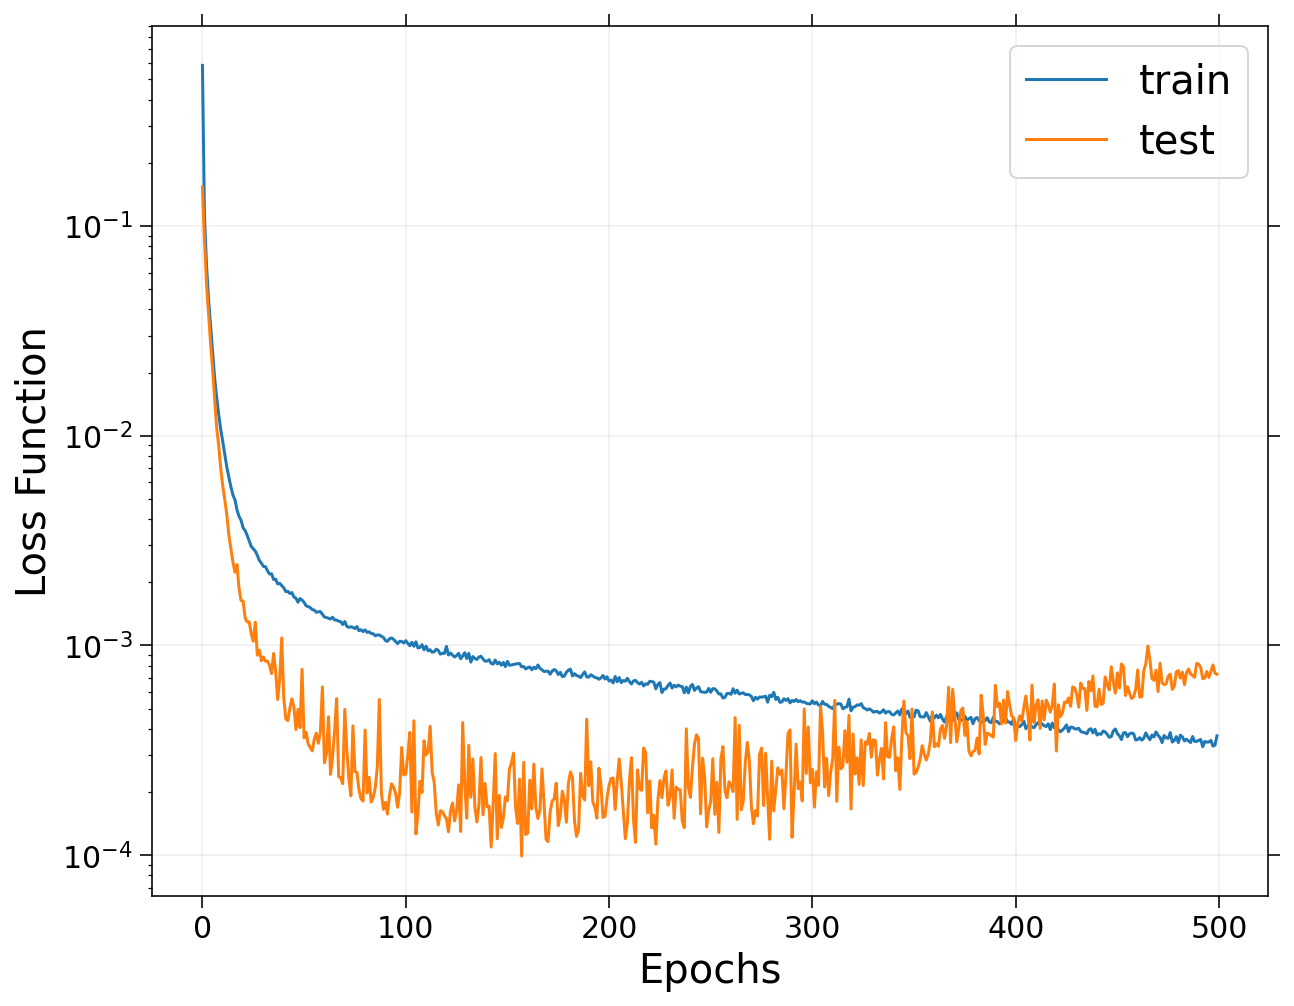

In [24]:
plt.figure(figsize = (10,8))
plt.plot(hist_nonlin.history["loss"], label="train")
plt.plot(hist_nonlin.history["val_loss"], label="test")
plt.legend(fontsize=20)
plt.yscale("log")
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.rc('axes', labelsize=16)
plt.rc('axes', labelsize=20, titlesize=20)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.grid(alpha=0.2)
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.savefig('Loss_Func_3dim_NL.pdf')
plt.tight_layout

H0: 64.0 - 80.0, Omega_b: 0.0180 - 0.0250, Omega_cdm: 0.050 - 0.250 64 0.018 0.05


parameter:  ['64', '0.018', '0.05']
user_list: [64.0, 0.018, 0.05]
cosmo_arr [[6.4e+01 1.8e-02 5.0e-02]]
cosmo_arr[0] [6.4e+01 1.8e-02 5.0e-02]
input_scaled [[-1.73193534 -1.73193534 -1.73193534]]
H0: 64.0 Omega_b: 0.018 Omega_c: 0.05


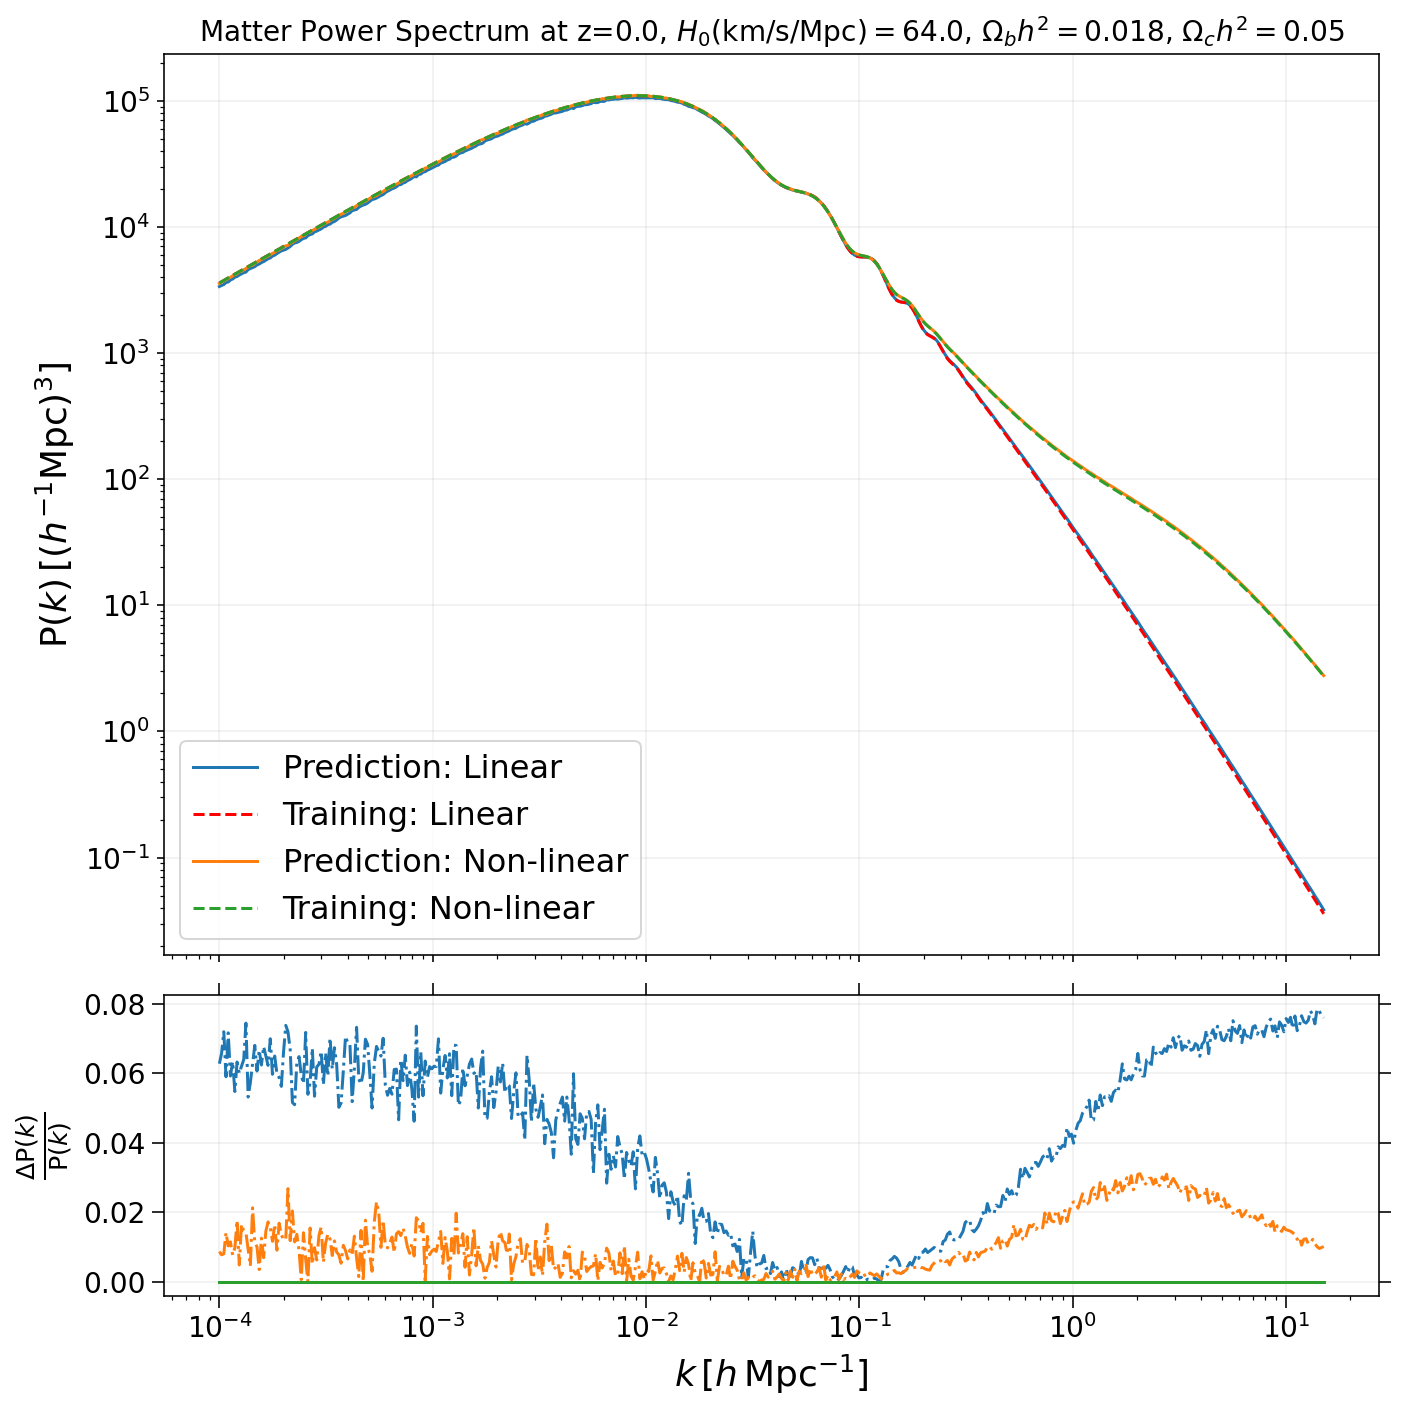

In [40]:
#Define func:

def calc_cosmo():
    input_cosmo_val = input('H0: 64.0 - 80.0, Omega_b: 0.0180 - 0.0250, Omega_cdm: 0.050 - 0.250 ')
    print("\n")
    user_list = input_cosmo_val.split()
    # print list
    print('parameter: ', user_list)

    # convert each item to float type
    for i in range(len(user_list)):
        # convert each item to float type
        user_list[i] = float(user_list[i])
    print("user_list:", user_list)
        
    
    cosmo_arr = np.reshape(np.array(user_list),(1, X_train.shape[1]))
    print('cosmo_arr', cosmo_arr)
    print('cosmo_arr[0]', cosmo_arr[0])
    scaled = train_input_data.fit(input_data.values)
    input_scaled = scaled.transform(cosmo_arr)
    print('input_scaled', input_scaled)
    
    pred_pk = np.exp(scaled_output.inverse_transform(tf_model.predict([input_scaled])))
    pred_pk_nonlin = np.exp(scaled_output.inverse_transform(tf_model_nonlin.predict([input_scaled])))
    #Return to log scale for pred:
    #pred_pk = np.exp(pred_rescaled_pk)
    
    
    #Compute P.S via CAMB:
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=cosmo_arr[0][0], ombh2=cosmo_arr[0][1], omch2=cosmo_arr[0][2])
    pars.InitPower.set_params(As = 2.105209331e-9, ns=0.9665)
    pars.set_matter_power(redshifts=[0.0], kmax=15.0)
    pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')

    # Linear spectra
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    camb_kh, z, camb_pk_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints=500)
    s8_current = np.array(results.get_sigma8())
    s8_fid = np.array([0.8102])
    renorm_s8 = (s8_fid/s8_current)**2
    camb_pk = renorm_s8*camb_pk_cur

    # Non-Linear spectra (Halofit)
    pars.NonLinear = model.NonLinear_both
    results.calc_power_spectra(pars)
    camb_kh_nonlin, z_nonlin, camb_pk_nonlin_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints = 500)
    camb_pk_nonlin = renorm_s8*camb_pk_nonlin_cur

    print('H0:' , cosmo_arr[0][0], 'Omega_b:', cosmo_arr[0][1], 'Omega_c:', cosmo_arr[0][2])
    #print(pred_pk)
    
    fig, ax = plt.subplots(2,1, sharex=True, figsize = (10,10), gridspec_kw={'height_ratios': [3, 1]})                                            
    ax[0].loglog(camb_kh, pred_pk[0], "C0")                                                                               
    ax[0].loglog(camb_kh, camb_pk[0], 'r', linestyle='dashed')     
    ax[0].loglog(camb_kh, pred_pk_nonlin[0], "C1")
    ax[0].loglog(camb_kh, camb_pk_nonlin[0], 'C2', linestyle='dashed') 
    ax[0].set_title('Matter Power Spectrum at z=0.0, $H_{0} \mathregular{(km/s/Mpc)} = %0.5s$, ' %cosmo_arr[0][0] + '$\Omega_{b}h^{2} = %0.6s$, ' %cosmo_arr[0][1] + '$\Omega_{c}h^{2} = %0.6s$' %cosmo_arr[0][2], fontsize = 14)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=16)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
    ax[0].set_ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
    ax[0].legend(['Prediction: Linear', 'Training: Linear', 'Prediction: Non-linear', 'Training: Non-linear'], loc='lower left', fontsize=16);
    ax[0].grid(alpha=0.2)
    ax[1].grid(alpha=0.2)
    plt.tick_params(top=True,right=True, length=6)
    
    #residual plot 
    ax[1].set_ylabel(r'$\frac{\Delta \mathrm{P}(k)}{\mathrm{P}(k)}$')
    ax[1].plot(camb_kh, np.abs((pred_pk[0]-camb_pk[0])/camb_pk[0]), 'C0', linestyle="dashdot") 
    ax[1].plot(camb_kh, np.abs((camb_pk[0]-camb_pk[0])/camb_pk[0]), 'r')
    ax[1].plot(camb_kh, np.abs((pred_pk_nonlin[0]-camb_pk_nonlin[0])/camb_pk_nonlin[0]), 'C1', linestyle="dashdot") 
    ax[1].plot(camb_kh, np.abs((camb_pk_nonlin[0]-camb_pk_nonlin[0])/camb_pk_nonlin[0]), 'C2')
    ax[1].set_yscale('linear')
    #ax[1].set_ylim(0, 0.05)
    fig.tight_layout()
    plt.savefig('NLMPS_3dim.pdf')
    plt.show()
    

Generate = calc_cosmo()

In [34]:
H0_input = np.linspace(64.0, 80.0, 8)
omega_b_input = np.linspace(0.0180, 0.0250, 8)
omega_c_input = np.linspace(0.050, 0.250, 8)
input_arr_trans = np.zeros((3,8))
input_arr_trans[0,:] = H0_input
input_arr_trans[1,:] = omega_b_input
input_arr_trans[2,:] = omega_c_input
input_arr = np.transpose(input_arr_trans)
input_arr = input_arr.astype(float)

In [41]:
input_arr

array([[6.40000000e+01, 1.80000000e-02, 5.00000000e-02],
       [6.62857143e+01, 1.90000000e-02, 7.85714286e-02],
       [6.85714286e+01, 2.00000000e-02, 1.07142857e-01],
       [7.08571429e+01, 2.10000000e-02, 1.35714286e-01],
       [7.31428571e+01, 2.20000000e-02, 1.64285714e-01],
       [7.54285714e+01, 2.30000000e-02, 1.92857143e-01],
       [7.77142857e+01, 2.40000000e-02, 2.21428571e-01],
       [8.00000000e+01, 2.50000000e-02, 2.50000000e-01]])



parameter:  [6.4e+01 1.8e-02 5.0e-02]
user_list: [6.4e+01 1.8e-02 5.0e-02]
cosmo_arr [[6.4e+01 1.8e-02 5.0e-02]]
cosmo_arr[0] [6.4e+01 1.8e-02 5.0e-02]
input_scaled [[-1.73193534 -1.73193534 -1.73193534]]


parameter:  [6.62857143e+01 1.90000000e-02 7.85714286e-02]
user_list: [6.62857143e+01 1.90000000e-02 7.85714286e-02]
cosmo_arr [[6.62857143e+01 1.90000000e-02 7.85714286e-02]]
cosmo_arr[0] [6.62857143e+01 1.90000000e-02 7.85714286e-02]
input_scaled [[-1.23709667 -1.23709667 -1.23709667]]


parameter:  [6.85714286e+01 2.00000000e-02 1.07142857e-01]
user_list: [6.85714286e+01 2.00000000e-02 1.07142857e-01]
cosmo_arr [[6.85714286e+01 2.00000000e-02 1.07142857e-01]]
cosmo_arr[0] [6.85714286e+01 2.00000000e-02 1.07142857e-01]
input_scaled [[-0.742258 -0.742258 -0.742258]]


parameter:  [7.08571429e+01 2.10000000e-02 1.35714286e-01]
user_list: [7.08571429e+01 2.10000000e-02 1.35714286e-01]
cosmo_arr [[7.08571429e+01 2.10000000e-02 1.35714286e-01]]
cosmo_arr[0] [7.08571429e+01 2.10000000

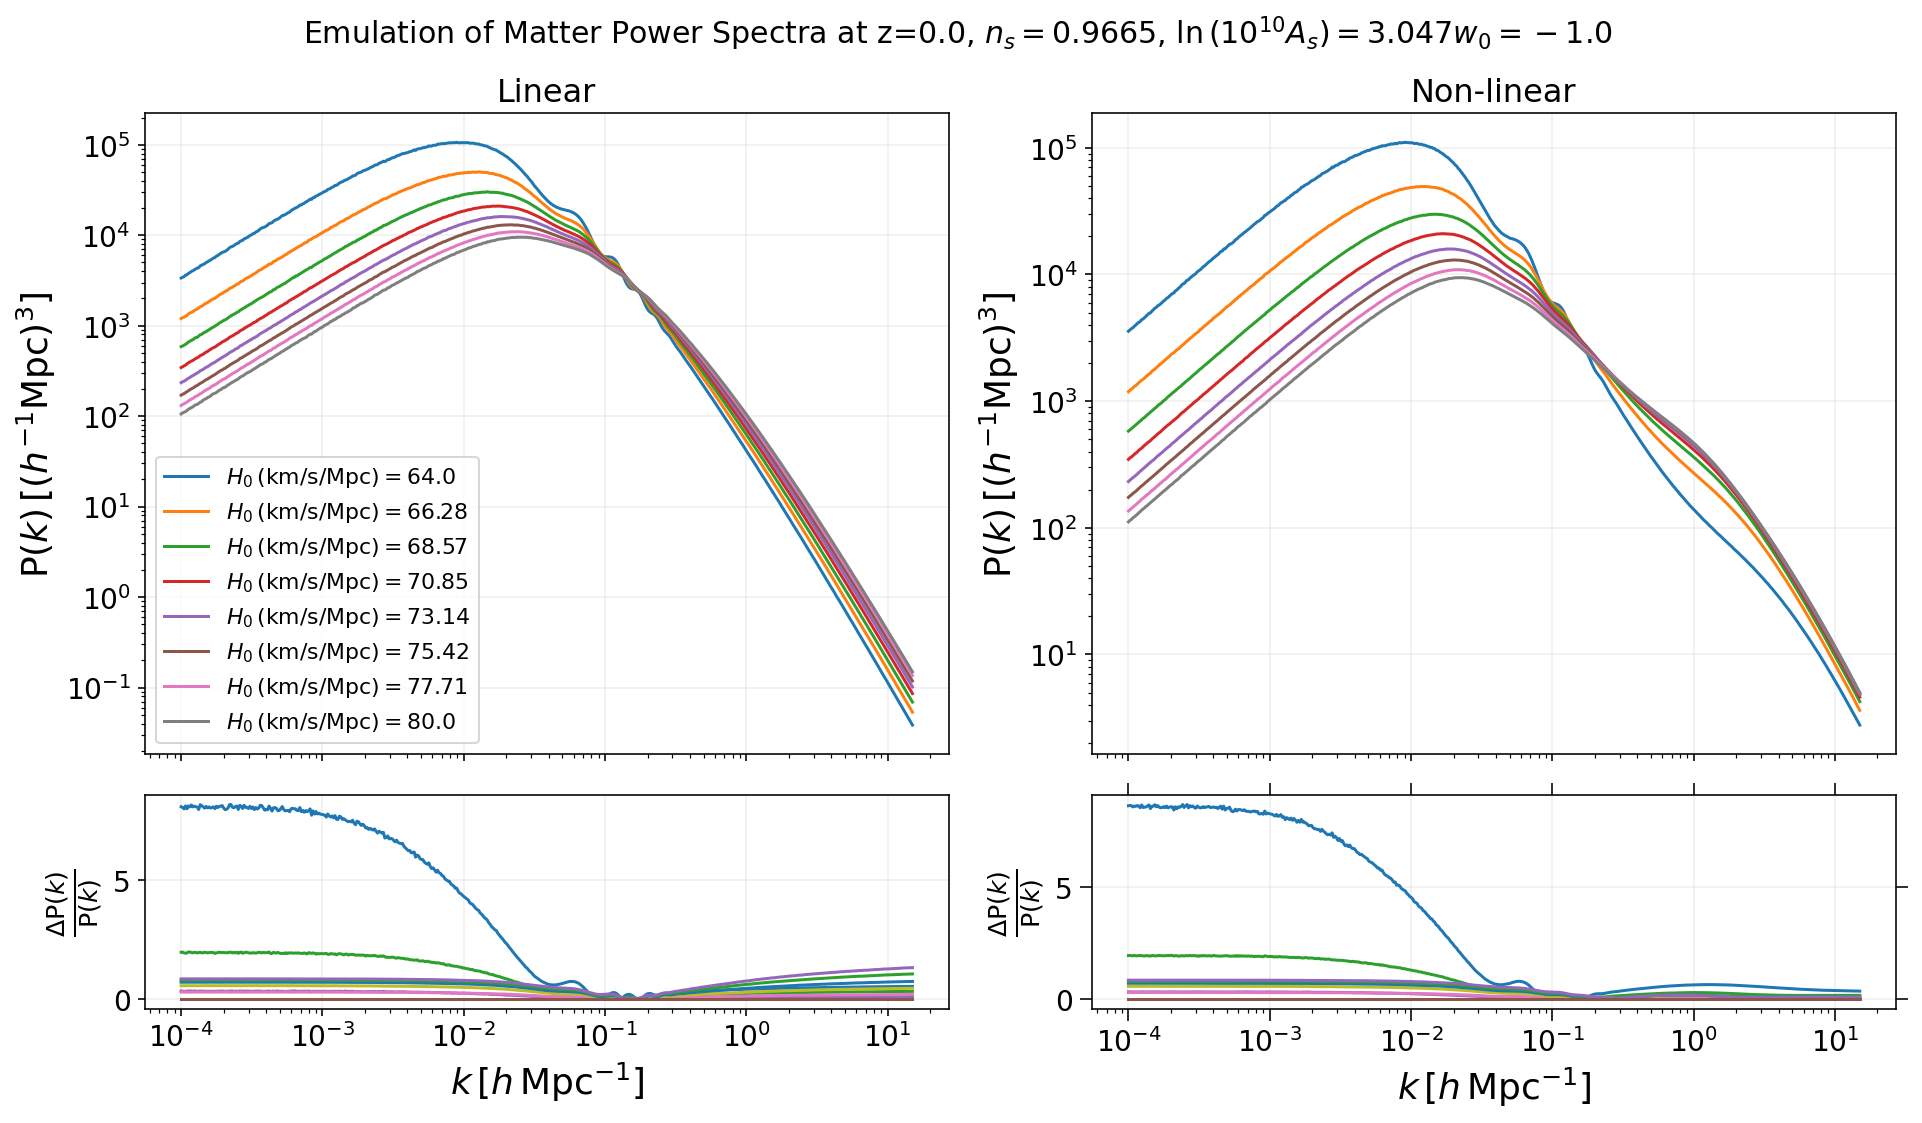

In [42]:
# Define func:

def calc_cosmo():
    
    fig, ax = plt.subplots(2,2, sharex=True, figsize = (13.5,8), gridspec_kw={'height_ratios': [3, 1]})
    for w in input_arr:
        
        print("\n")
        user_list = w.astype(float)
        # print list
        print('parameter: ', user_list)

        # convert each item to float type
        print("user_list:", user_list)
        
    
        cosmo_arr = np.reshape(np.array(user_list),(1, X_train.shape[1]))
        print('cosmo_arr', cosmo_arr)
        print('cosmo_arr[0]', cosmo_arr[0])
        scaled = train_input_data.fit(input_data.values)
        input_scaled = scaled.transform(cosmo_arr)
        print('input_scaled', input_scaled)

        pred_pk = np.exp(scaled_output.inverse_transform(tf_model.predict([input_scaled])))
        pred_pk_nonlin = np.exp(scaled_output.inverse_transform(tf_model_nonlin.predict([input_scaled])))
        #Return to log scale for pred:
        #pred_pk = np.exp(pred_rescaled_pk)
    
    
        #Compute P.S via CAMB:
        pars = camb.CAMBparams()
        pars.set_cosmology(H0=cosmo_arr[0][0], ombh2=0.02242, omch2=0.11933)
        pars.InitPower.set_params(As = 2.105209331e-9, ns=0.9665)
        pars.set_matter_power(redshifts=[0.0], kmax=15.0)
        pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')

        # Linear spectra
        pars.NonLinear = model.NonLinear_none
        results = camb.get_results(pars)
        camb_kh, z, camb_pk_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints=500)
        s8_current = np.array(results.get_sigma8())
        s8_fid = np.array([0.8102])
        renorm_s8 = (s8_fid/s8_current)**2
        camb_pk = renorm_s8*camb_pk_cur
        
        
        # Non-Linear spectra (Halofit)
        pars.NonLinear = model.NonLinear_both
        results.calc_power_spectra(pars)
        camb_kh_nonlin, z_nonlin, camb_pk_nonlin_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints = 500)
        camb_pk_nonlin = renorm_s8*camb_pk_nonlin_cur


        #print('H0:' , cosmo_arr[0][0])
        
                                             
        ax[0,0].loglog(camb_kh, pred_pk[0])                                                                       
        ax[0,1].loglog(camb_kh, pred_pk_nonlin[0])
        
        #residual plot 
        ax[1,0].set_ylabel(r'$\frac{\Delta \mathrm{P}(k)}{\mathrm{P}(k)}$')
        ax[1,0].plot(camb_kh, np.abs((pred_pk[0]-camb_pk[0])/camb_pk[0]) 
        ax[1,0].plot(camb_kh, np.abs((camb_pk[0]-camb_pk[0])/camb_pk[0]))
        ax[1,0].set_yscale('linear')
        
        ax[1,1].set_ylabel(r'$\frac{\Delta \mathrm{P}(k)}{\mathrm{P}(k)}$')
        ax[1,1].plot(camb_kh, np.abs((pred_pk_nonlin[0]-camb_pk_nonlin[0])/camb_pk_nonlin[0]) 
        ax[1,1].plot(camb_kh, np.abs((camb_pk_nonlin[0]-camb_pk_nonlin[0])/camb_pk_nonlin[0]))
        ax[1,1].set_yscale('linear')
        #ax[1].set_ylim(0, 0.05)
        
    fig.suptitle('Emulation of Matter Power Spectra at z=0.0, ' + '$n_{s} = 0.9665$, ' + '$\ln{(10^{10}A_{s})} = 3.047$' + '$w_{0} = -1.0$', fontsize = 15)
    ax[0,0].set_title('Linear')
    ax[0,1].set_title('Non-linear')
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=16)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    ax[1,0].set_xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
    ax[1,1].set_xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
    ax[0,0].set_ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
    ax[0,1].set_ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
    ax[0,0].legend(["$H_{0}\,\mathregular{(km/s/Mpc)} = %0.5s$"%w for w in  H0_input], loc='lower left', fontsize=11);
#     ax[0,1].legend(["$H_{0}\,\mathregular{(km/s/Mpc)} = %0.5s$"%w for w in  H0_input], loc='lower left', fontsize=11);
    ax[0,0].grid(alpha=0.2)
    ax[1,0].grid(alpha=0.2)
    ax[0,1].grid(alpha=0.2)
    ax[1,1].grid(alpha=0.2)
    plt.tick_params(top=True,right=True, length=6)


        
    fig.tight_layout()
    plt.savefig('NLMPS_3dim_range.pdf')
    plt.show()
    

Generate = calc_cosmo()

#Define func:

def calc_cosmo():
    fig, ax = plt.subplots(1,2, sharex=True, figsize = (16,8)) #, gridspec_kw={'height_ratios': [3, 1]}
    for w in input_arr:
        
        print("\n")
        user_list = w.astype(float)
        # print list
        print('parameter: ', user_list)

        # convert each item to float type
        print("user_list:", user_list)
        
    
        cosmo_arr = np.reshape(np.array(user_list),(1, X_train.shape[1]))
        print('cosmo_arr', cosmo_arr)
        print('cosmo_arr[0]', cosmo_arr[0])
        scaled = train_input_data.fit(input_data.values)
        input_scaled = scaled.transform(cosmo_arr)
        print('input_scaled', input_scaled)

        pred_pk = np.exp(scaled_output.inverse_transform(tf_model.predict([input_scaled])))
        pred_pk_nonlin = np.exp(scaled_output.inverse_transform(tf_model_nonlin.predict([input_scaled])))
        #Return to log scale for pred:
        #pred_pk = np.exp(pred_rescaled_pk)
    
    
        #Compute P.S via CAMB:
        pars = camb.CAMBparams()
        pars.set_cosmology(H0=cosmo_arr[0][0], ombh2=0.02242, omch2=0.11933)
        pars.InitPower.set_params(As = 2.105209331e-9, ns=0.9665)
        pars.set_matter_power(redshifts=[0.0], kmax=15.0)
        pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')

        # Linear spectra
        pars.NonLinear = model.NonLinear_none
        results = camb.get_results(pars)
        camb_kh, z, camb_pk_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints=500)
        s8_current = np.array(results.get_sigma8())
        s8_fid = np.array([0.8102])
        renorm_s8 = (s8_fid/s8_current)**2
        camb_pk = renorm_s8*camb_pk_cur

        # Non-Linear spectra (Halofit)
        pars.NonLinear = model.NonLinear_both
        results.calc_power_spectra(pars)
        camb_kh_nonlin, z_nonlin, camb_pk_nonlin_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints = 500)
        camb_pk_nonlin = renorm_s8*camb_pk_nonlin_cur

        print('H0:' , cosmo_arr[0][0])
                                            
        ax[0].loglog(camb_kh, pred_pk[0])                                                                                   
        ax[1].loglog(camb_kh, pred_pk_nonlin[0])                                                  
    fig.suptitle('Emulation of Matter Power Spectrum at z=0.0, ' + '$\Omega_{b}h^{2} = 0.02242$, ' + '$\Omega_{c}h^{2} = 0.11933$, ', fontsize = 14)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=16)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    ax[0].set_xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
    ax[0].set_ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
    #ax[0].legend(["$H_{0}\,\mathregular{(km/s/Mpc)} = %0.5s$"%w for w in input_arr[:,0], "$\Omega_{b}h^{2} = %0.6s$"%w for w in input_arr[:,1], "$\Omega_{c}h^{2} = %0.5s$"%w for w in input_arr[:,0] ], loc='lower left', fontsize=16);
    #ax[0].legend(["$H_{0}\,\mathregular{(km/s/Mpc)} = %0.5s$"%w for w in input_arr ], loc='lower left', fontsize=16);
    ax[0].grid(alpha=0.2)
    ax[1].grid(alpha=0.2)
    ax[0].tick_params(top=True,right=True, length=6)
    
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=16)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    ax[1].set_xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
    ax[1].set_ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
    #ax[1].legend(["$%0.5s$"%w for w in input_arr ], loc='lower left', fontsize=16);
    ax[1].tick_params(top=True,right=True, length=6)

    fig.tight_layout()
    #plt.savefig('NNMPS_3dim_range.jpg')
    plt.show()
    

Generate = calc_cosmo()